In [21]:
import argparse
import os
import numpy as np
import pandas as pd
from nsd_access import NSDAccess
import scipy.io

from config import NSD_ROOT_DIR, DATA_ROOT_DIR
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--subject",
        type=str,
        default=None,
        help="subject name: subj01 or subj02  or subj05  or subj07 for full-data subjects ",
    )
    return parser.parse_args()

# name : each or ave
def write_index(sharedix, stims, name, save_dir):
    feats = []
    tr_idx = np.zeros(len(stims))
    for idx, s in tqdm(enumerate(stims)): 
        if s in sharedix:
            tr_idx[idx] = 0
        else:
            tr_idx[idx] = 1    
        feats.append(s)
    
    feats = np.stack(feats)

    feats_tr = feats[tr_idx==1]
    feats_te = feats[tr_idx==0]

    np.save(f'{save_dir}/index_{name}_tr.npy',feats_tr)
    np.save(f'{save_dir}/index_{name}_te.npy',feats_te)


In [22]:
# opt = parse_args()

# subject = opt.subject
subject = 'subj01'
atlasname = 'streams'

nsda = NSDAccess(NSD_ROOT_DIR)
nsd_expdesign = scipy.io.loadmat(os.path.join(NSD_ROOT_DIR, 'nsddata/experiments/nsd/nsd_expdesign.mat'))

# Note that most of nsd_expdesign indices are 1-base index!
# This is why subtracting 1
sharedix = nsd_expdesign['sharedix'] -1 

behs = pd.DataFrame()
for i in range(1,38):
    beh = nsda.read_behavior(subject=subject, 
                            session_index=i)
    behs = pd.concat((behs,beh))

# Caution: 73KID is 1-based! https://cvnlab.slite.page/p/fRv4lz5V2F/Behavioral-data
stims_unique = behs['73KID'].unique() - 1
stims_all = behs['73KID'] - 1

savedir = os.path.join(DATA_ROOT_DIR, f'mrifeat/{subject}/')

os.makedirs(savedir, exist_ok=True)

if not os.path.exists(f'{savedir}/{subject}_stims.npy'):
    np.save(f'{savedir}/{subject}_stims.npy',stims_all)
    np.save(f'{savedir}/{subject}_stims_ave.npy',stims_unique)

write_index(sharedix, stims_all, 'each', savedir)
write_index(sharedix, stims_unique, 'ave', savedir)
# exit(0)

atlas = nsda.read_atlas_results(subject=subject, atlas=atlasname, data_format='func1pt8mm')


27750it [00:00, 280890.94it/s]
9841it [00:00, 283037.07it/s]


In [23]:
print(atlas[0].shape)
print(atlas[1])

(81, 104, 83)
{'Unknown': 0, 'early': 1, 'midventral': 2, 'midlateral': 3, 'midparietal': 4, 'ventral': 5, 'lateral': 6, 'parietal': 7}


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

array = atlas[0]

# 选择要绘制的切片的索引
for slice_index in range(0, 0):

    # 获取切片数据
    slice_data = array[:, :, slice_index]

    # 绘制切片
    plt.imshow(slice_data, cmap='grey')
    plt.colorbar()
    plt.title('Slice at index {}'.format(slice_index))
    plt.show()

# 统计 array 中 >-1 的元素个数
print('Number of elements > 0:', np.sum(array > 0))

Number of elements > 0: 27638


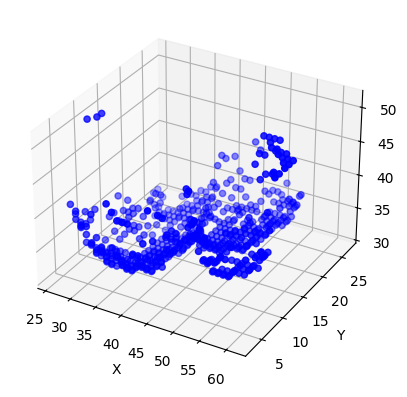

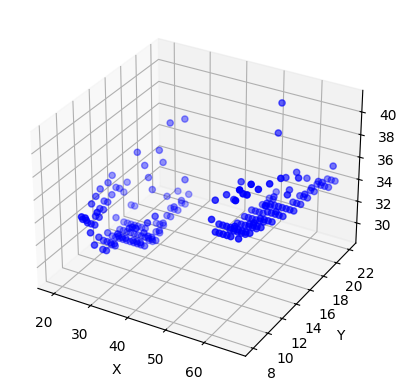

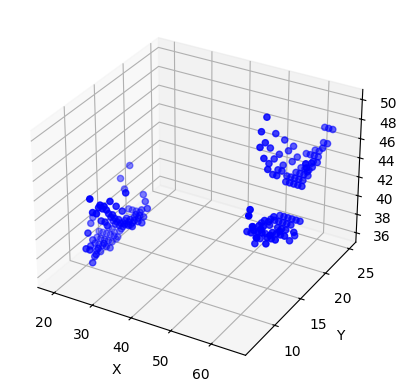

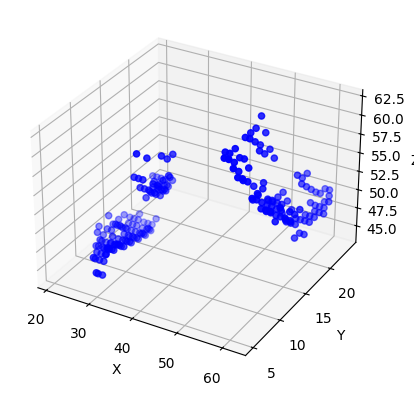

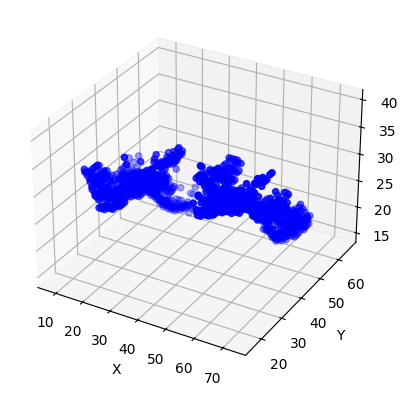

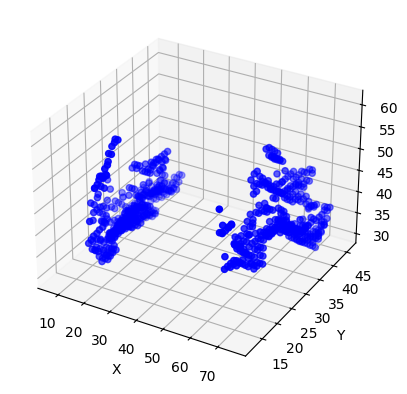

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for v in range(1, 7):
    # 生成随机三维点
    x = []
    y = []
    z = []
    for i in range(atlas[0].shape[0]):
        for j in range(atlas[0].shape[1]):
            for k in range(atlas[0].shape[2]):
                if atlas[0][i,j,k] == v:
                    x.append(i)
                    y.append(j)
                    z.append(k)
                    break

    # 创建三维图形对象
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制散点图
    ax.scatter(x, y, z, c='b', marker='o')

    # 设置坐标轴标签
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # 显示图形
    plt.show()

In [ ]:
import numpy as np
mapper_results = nsda.read_mapper_results(subject=subject,
                                        #   data_type='gain',
                                        #   data_type='eccentricity',
                                          data_format='func1pt8mm')
print(mapper_results)
print(mapper_results.get_fdata())
# print(np.asanyarray(mapper_results.dataobj))


In [ ]:
for i in tqdm(range(1,38), desc = 'reading betas'):
    beta_trial = nsda.read_betas(subject=subject, 
                            session_index=i, 
                            trial_index=[], # empty list as index means get all for this session
                            data_type='betas_fithrf_GLMdenoise_RR',
                            data_format='func1pt8mm')
    if i==1:
        betas_all = beta_trial
    else:
        betas_all = np.concatenate((betas_all,beta_trial),0)    


In [ ]:

for roi,val in atlas[1].items():
    print(roi,val)
    if val == 0:
        print('SKIP')
        continue
    else:
        betas_roi = betas_all[:,atlas[0].transpose([2,1,0])==val]

    print(betas_roi.shape)
    
    # Averaging for each stimulus
    betas_roi_ave = []
    for stim in stims_unique:
        stim_mean = np.mean(betas_roi[stims_all == stim,:],axis=0)
        betas_roi_ave.append(stim_mean)
    betas_roi_ave = np.stack(betas_roi_ave)
    print(betas_roi_ave.shape)
    
    # Train/Test Split
    # ALLDATA
    betas_tr = []
    betas_te = []

    for idx,stim in enumerate(stims_all):
        if stim in sharedix:
            betas_te.append(betas_roi[idx,:])
        else:
            betas_tr.append(betas_roi[idx,:])

    betas_tr = np.stack(betas_tr)
    betas_te = np.stack(betas_te)    
    
    # AVERAGED DATA        
    betas_ave_tr = []
    betas_ave_te = []
    for idx,stim in enumerate(stims_unique):
        if stim in sharedix:
            betas_ave_te.append(betas_roi_ave[idx,:])
        else:
            betas_ave_tr.append(betas_roi_ave[idx,:])
    betas_ave_tr = np.stack(betas_ave_tr)
    betas_ave_te = np.stack(betas_ave_te)    

    scaler = StandardScaler()
    betas_tr = scaler.fit_transform(betas_tr)
    betas_te = scaler.transform(betas_te)

    scaler = StandardScaler()
    betas_ave_tr = scaler.fit_transform(betas_ave_tr)
    betas_ave_te = scaler.transform(betas_ave_te)
    
    # Save
    np.save(f'{savedir}/{subject}_{roi}_betas_tr.npy',betas_tr)
    np.save(f'{savedir}/{subject}_{roi}_betas_te.npy',betas_te)
    np.save(f'{savedir}/{subject}_{roi}_betas_ave_tr.npy',betas_ave_tr)
    np.save(f'{savedir}/{subject}_{roi}_betas_ave_te.npy',betas_ave_te)